# House Prices - Advanced Regression Techniques: Predict sales prices and practice feature engineering, RFs, and gradient boosting

# 1. Data Exploration and Preprocessing

## Load and Exploring the dataset

In [246]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [247]:
pd.set_option('display.max_columns', None)

In [248]:
df1 = pd.read_csv('data_downloaded/train.csv')
df_test = pd.read_csv('data_downloaded/test.csv')
print(f"Train Data : {df1.shape}")
print(f"Test Data : {df_test.shape}")

Train Data : (1460, 81)
Test Data : (1459, 80)


## Handling Missing Values

In [249]:
replacement_dictionary = {
                            'PoolQC'      : 'No Pool',
                            'MiscFeature' : 'No MiscFeatures',  
                            'Alley'       : 'No Alley Access',
                            'Fence'       : 'No Fence',
                            'FireplaceQu' : 'No FirePlace', 
                            'GarageFinish': 'No Garage',
                            'GarageQual'  : 'No Garage',
                            'GarageCond'  : 'No Garage',
                            'GarageType'  : 'No Garage',
                            'BsmtExposure': 'No Basement',
                            'BsmtCond'    : 'No Basement',
                            'BsmtQual'    : 'No Basement',
                            'BsmtFinType2': 'No Basement',
                            'BsmtFinType1': 'No Basement',
                            'Electrical'  : 'No Electrical',
                            'MasVnrType'  : 'No MasVnr',
                            'MasVnrArea'  : 0,
                            'LotFrontage' : 0,
                            'GarageYrBlt' : 0}

In [250]:
from data_downloaded.fatih_missing_values import Dealing_missing_values

In [251]:
missing_handler = Dealing_missing_values(df1)

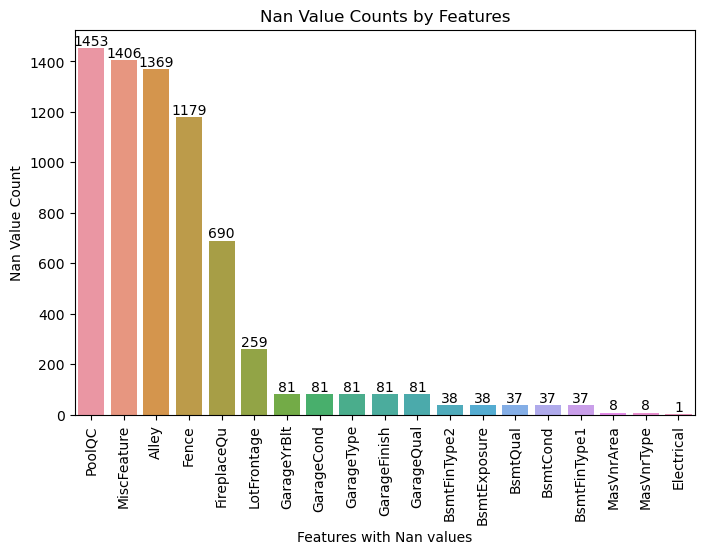

In [252]:
missing_handler.show_missing_values()

In [253]:
missing_handler.replace(replacement_dictionary)

In [254]:
missing_handler.show_missing_values()

There are no missing values


In [255]:
df2 = df1.copy()
print(df1.shape, ' ---> ', df2.shape)

(1460, 81)  --->  (1460, 81)


**Test Data**

In [256]:
# For Test Data
missing_handler_test = Dealing_missing_values(df_test)
missing_handler_test.replace(replacement_dictionary)
missing_handler_test.mmm(['MSZoning', 'Functional', 'Utilities', 'Exterior2nd', 'Exterior1st', 'SaleType', 'KitchenQual'], 'mode')

replacement_dictionary_test = {'BsmtFullBath':0, 'BsmtHalfBath':0, 'BsmtFinSF2':0, 'GarageArea':0, 'BsmtFinSF1':0, 'GarageCars':0, 'TotalBsmtSF':0,
        'BsmtUnfSF':0}

missing_handler_test.replace(replacement_dictionary_test)
missing_handler_test.show_missing_values()

There are no missing values


In [257]:
df_test_2 = df_test.copy()
print(df_test.shape, ' ---> ', df_test_2.shape)

(1459, 80)  --->  (1459, 80)


## Feature Engineering

### Summarizing Features: Creating new Features and drop old ones

In [258]:
# Hold 'GrLivArea' / drop '1stFlrSF', '2ndFlrSF'

# Hold 'TotRmsAbvGrd' / drop 'BedroomAbvGr'

# Create Total Bathrooms / drop 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
df2['Total_Bathrooms'] = df2['BsmtFullBath'] + df2['FullBath'] + 0.5*(df2['BsmtHalfBath'] + df2['HalfBath'])

# Create Age of the House / drop 'YearBuilt'
df2['Age_of_Property'] = df2['YearBuilt'].max() - df2['YearBuilt']

# Create 'Age_of_Renovation' / drop 'YearRemodAdd'
df2['Age_of_Renovation'] = df2['YearBuilt'].max() - df2['YearRemodAdd']

# Hold 'GarageArea', create 'Has_Garage' binary / drop 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond'
df2['HasGarage'] = (df2['GarageType'] != 'No Garage').astype(int)

In [259]:
# Create 'Neibhborhood_MedianP' / drop 'Neighborhood'
neighborhood_median_price = df2.groupby('Neighborhood')['SalePrice'].median().reset_index()
neighborhood_median_price.columns = ['Neighborhood', 'MedianHousePrice']
df2 = pd.merge(df2, neighborhood_median_price, on='Neighborhood', how='left')

In [260]:
# Define different mappings for each basement features (because we will make math operations/grading)
bsmt_qual_mapping = {'Ex':5, 'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'No Basement': 0}
bsmt_cond_mapping = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'No Basement': 0}
bsmt_exposure_mapping = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'No Basement': 0}
bsmt_fintype_mapping = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'No Basement': 0}

# Convert the categorical str values into grade points by mapping function
df2['BsmtFinType1'] = df2['BsmtFinType1'].map(bsmt_fintype_mapping)
df2['BsmtFinType2'] = df2['BsmtFinType2'].map(bsmt_fintype_mapping)
df2['BsmtQual'] = df2['BsmtQual'].map(bsmt_qual_mapping)
df2['BsmtCond'] = df2['BsmtCond'].map(bsmt_cond_mapping)
df2['BsmtExposure'] = df2['BsmtExposure'].map(bsmt_exposure_mapping)

# FinType has a numeric grade and a corresponding sqfoot, combine them
df2['BsmtFinGrade'] = (df2['BsmtFinType1'] * df2.BsmtFinSF1 / df2.TotalBsmtSF) + \
                      (df2['BsmtFinType2'] * df2.BsmtFinSF2 / df2.TotalBsmtSF) + \
                      (df2['BsmtFinType1'] * df2.BsmtUnfSF / df2.TotalBsmtSF)

# Because of zero division there will be Nan values where there are no basement, since TotalBsmtSf == 0
df2['BsmtFinGrade'].fillna(0.0, inplace=True)

# Combine into one single 'BsmtOverallGrade'
df2['BsmtOverallGrade'] = round((df2['BsmtQual'] + df2['BsmtCond'] + df2['BsmtExposure'] + df2['BsmtFinGrade']), 2)

# Drop :
# 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 
# 'BsmtFinSF2','BsmtUnfSF','BsmtFinGrade'

In [261]:
# Create 'Terrace_Grade' / drop 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
terrace_columns = ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
terrace_weights = [1, 1, 2, 2, 2]

df2['Terrace_Grade'] = np.dot(df2[terrace_columns], terrace_weights)

__Dropping the columns__

In [262]:
col_drop_feat_eng = ['1stFlrSF', '2ndFlrSF', 'BedroomAbvGr',
                     'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 
                    'YearBuilt', 'YearRemodAdd', 
                    'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond',
                    'Neighborhood', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1','BsmtFinType2', 
                    'BsmtFinSF2','BsmtUnfSF','BsmtFinGrade',
                    'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']

In [263]:
df3 = df2.drop(columns=col_drop_feat_eng)
df3.shape

(1460, 59)

In [264]:
df3.sample(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,LowQualFinSF,GrLivArea,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
703,704,190,RM,76.0,7630,Pave,No Alley Access,Reg,Lvl,AllPub,Inside,Gtl,Feedr,Norm,2fmCon,2Story,5,9,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.0,TA,Gd,BrkTil,360,GasA,Gd,Y,SBrkr,0,1812,2,Gd,8,Typ,1,Po,672,N,0,No Pool,MnPrv,No MiscFeatures,0,5,2010,WD,Normal,140000,2.0,110,14,1,119000.0,9.0,424
206,207,20,RL,40.0,13673,Pave,No Alley Access,IR1,Lvl,AllPub,CulDSac,Gtl,RRAe,Norm,1Fam,1Story,5,5,Gable,CompShg,HdBoard,HdBoard,None,0.0,TA,Gd,CBlock,1140,GasA,TA,Y,SBrkr,0,1696,1,TA,8,Min2,1,TA,349,Y,0,No Pool,No Fence,No MiscFeatures,0,3,2007,WD,Normal,143900,1.5,48,48,1,135000.0,8.0,30


**Test Data**

In [265]:
# Create Total Bathrooms / drop 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath'
df_test_2['Total_Bathrooms'] = df_test_2['BsmtFullBath'] + df_test_2['FullBath'] + 0.5*(df_test_2['BsmtHalfBath'] + df_test_2['HalfBath'])

# Create Age of the House / drop 'YearBuilt'
df_test_2['Age_of_Property'] = df_test_2['YearBuilt'].max() - df_test_2['YearBuilt']

# Create 'Age_of_Renovation' / drop 'YearRemodAdd'
df_test_2['Age_of_Renovation'] = df_test_2['YearBuilt'].max() - df_test_2['YearRemodAdd']

# Hold 'GarageArea', create 'Has_Garage' binary / drop 'GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageQual','GarageCond'
df_test_2['HasGarage'] = (df_test_2['GarageType'] != 'No Garage').astype(int)

In [266]:
# Create 'Neibhborhood_MedianP' / drop 'Neighborhood'
df_test_2 = pd.merge(df_test_2, neighborhood_median_price, on='Neighborhood', how='left')

In [267]:
# Convert the categorical str values into grade points by mapping function
df_test_2['BsmtFinType1'] = df_test_2['BsmtFinType1'].map(bsmt_fintype_mapping)
df_test_2['BsmtFinType2'] = df_test_2['BsmtFinType2'].map(bsmt_fintype_mapping)
df_test_2['BsmtQual'] = df_test_2['BsmtQual'].map(bsmt_qual_mapping)
df_test_2['BsmtCond'] = df_test_2['BsmtCond'].map(bsmt_cond_mapping)
df_test_2['BsmtExposure'] = df_test_2['BsmtExposure'].map(bsmt_exposure_mapping)

# FinType has a numeric grade and a corresponding sqfoot, combine them
df_test_2['BsmtFinGrade'] = (df_test_2['BsmtFinType1'] * df_test_2.BsmtFinSF1 / df_test_2.TotalBsmtSF) + \
                      (df_test_2['BsmtFinType2'] * df_test_2.BsmtFinSF2 / df_test_2.TotalBsmtSF) + \
                      (df_test_2['BsmtFinType1'] * df_test_2.BsmtUnfSF / df_test_2.TotalBsmtSF)

# Because of zero division there will be Nan values where there are no basement, since TotalBsmtSf == 0
df_test_2['BsmtFinGrade'].fillna(0.0, inplace=True)

# Combine into one single 'BsmtOverallGrade'
df_test_2['BsmtOverallGrade'] = round((df_test_2['BsmtQual'] + df_test_2['BsmtCond'] + df_test_2['BsmtExposure'] + df_test_2['BsmtFinGrade']), 2)

In [268]:
# Create 'Terrace_Grade' / drop 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch'
df_test_2['Terrace_Grade'] = np.dot(df_test_2[terrace_columns], terrace_weights)

In [269]:
df_test_3 = df_test_2.drop(columns=col_drop_feat_eng)
print(df_test_2.shape, ' ---> ', df_test_3.shape)

(1459, 88)  --->  (1459, 58)


### High and Low Cardinality

Cardinality is an issue for categorical variables. But our df has some cat vars in numerical vars as well 

In [270]:
from data_downloaded.fatih_eda import plot_histograms_for_all_numeric, plot_barplot_all_categoric

In [271]:
cat_feat_check_cardinality = ['Id', 'KitchenAbvGr', 'HasGarage', 'Street', 'Alley', 'Utilities', 
                              'Condition1', 'Condition2', 'RoofMatl', 'ExterCond', 'Heating', 'CentralAir', 
                              'Electrical', 'Functional', 'PavedDrive', 'PoolQC', 'MiscFeature', 'SaleType', 'SaleCondition'  ]
cont_feat_check_cardinalty = ['LowQualFinSF', 'PoolArea', 'MiscVal' ]

In [272]:
# I can Check the correlations of suspicious low-varied features with Target, if low i can drop them
cardinality_drop_columns = []
for col in cont_feat_check_cardinalty:
    coref = df3[col].corr(df3['SalePrice'])
    if abs(coref) < 0.1:
        cardinality_drop_columns.append(col)
        print(f"Correlation of {col} with Sale Price is {coref}")
    
# drop 'LowQualFinSF', 'PoolArea', 'MiscVal'

Correlation of LowQualFinSF with Sale Price is -0.02560613000067956
Correlation of PoolArea with Sale Price is 0.09240354949187322
Correlation of MiscVal with Sale Price is -0.02118957964030325


In [273]:
# I can check value_counts % of categorical and so called categorical variables

for col in cat_feat_check_cardinality:
    vc_df = df3[col].value_counts(normalize=True).sort_values(ascending=False).reset_index()
    freq = round(vc_df.iloc[0,1], 3)
    value = vc_df.iloc[0,0]
    if (freq > 0.95) or (freq < 0.03):
        cardinality_drop_columns.append(col)
        print(f"{col.ljust(15)} -- {str(value).ljust(15)} -- {freq}")

Id              -- 1               -- 0.001
KitchenAbvGr    -- 1               -- 0.953
Street          -- Pave            -- 0.996
Utilities       -- AllPub          -- 0.999
Condition2      -- Norm            -- 0.99
RoofMatl        -- CompShg         -- 0.982
Heating         -- GasA            -- 0.978
PoolQC          -- No Pool         -- 0.995
MiscFeature     -- No MiscFeatures -- 0.963


In [274]:
cardinality_drop_columns

['LowQualFinSF',
 'PoolArea',
 'MiscVal',
 'Id',
 'KitchenAbvGr',
 'Street',
 'Utilities',
 'Condition2',
 'RoofMatl',
 'Heating',
 'PoolQC',
 'MiscFeature']

In [275]:
df4 = df3.drop(columns=cardinality_drop_columns)

In [276]:
print(df3.shape, '--->', df4.shape)

(1460, 59) ---> (1460, 47)


## Outliers

In [277]:
from data_downloaded.fatih_eda import FatihOutliers

In [278]:
outliers = FatihOutliers(df4)

In [279]:
o1 = outliers.show_outliers_for_features('LotFrontage')
o1

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
934,20,RL,313.0,27650,No Alley Access,IR2,HLS,Inside,Mod,PosA,1Fam,1Story,7,7,Flat,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,585,Ex,Y,SBrkr,2069,Gd,9,Typ,1,Gd,505,Y,No Fence,11,2008,WD,Normal,242000,3.0,50,3,1,140000.0,17.0,0
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,Ex,12,Typ,3,Gd,1418,Y,No Fence,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [280]:
o2 = outliers.show_outliers_for_features('MasVnrArea').sort_values(by='MasVnrArea', ascending=False).head(2)
o2

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
297,60,FV,66.0,7399,Pave,IR1,Lvl,Inside,Gtl,Norm,1Fam,2Story,7,5,Hip,VinylSd,VinylSd,BrkFace,1600.0,Gd,TA,PConc,975,Ex,Y,SBrkr,1950,Gd,7,Typ,1,TA,576,Y,No Fence,6,2007,WD,Normal,239000,2.5,13,12,1,225500.0,12.0,406
1169,60,RL,118.0,35760,No Alley Access,IR1,Lvl,CulDSac,Gtl,Norm,1Fam,2Story,10,5,Hip,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,1930,Ex,Y,SBrkr,3627,Gd,10,Typ,1,TA,807,Y,No Fence,7,2006,WD,Normal,625000,4.5,15,14,1,301500.0,18.0,437


In [281]:
o3 = outliers.show_outliers_for_features('TotalBsmtSF').sort_values(by='TotalBsmtSF', ascending=False).head(1)
o3

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,Ex,12,Typ,3,Gd,1418,Y,No Fence,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [282]:
o4 = outliers.show_outliers_for_features('GrLivArea')
o4

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
523,60,RL,130.0,40094,No Alley Access,IR1,Bnk,Inside,Gtl,PosN,1Fam,2Story,10,5,Hip,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,3138,Ex,Y,SBrkr,4676,Ex,11,Typ,1,Gd,884,Y,No Fence,10,2007,New,Partial,184750,4.5,3,2,1,121750.0,18.0,614
691,60,RL,104.0,21535,No Alley Access,IR1,Lvl,Corner,Gtl,Norm,1Fam,2Story,10,6,Gable,HdBoard,HdBoard,BrkFace,1170.0,Ex,TA,PConc,2444,Ex,Y,SBrkr,4316,Ex,10,Typ,2,Ex,832,Y,No Fence,1,2007,WD,Normal,755000,4.0,16,15,1,301500.0,18.0,432
1182,60,RL,160.0,15623,No Alley Access,IR1,Lvl,Corner,Gtl,Norm,1Fam,2Story,10,5,Hip,Wd Sdng,ImStucc,None,0.0,Gd,TA,PConc,2396,Ex,Y,SBrkr,4476,Ex,10,Typ,2,TA,813,Y,MnPrv,7,2007,WD,Abnorml,745000,4.5,14,14,1,301500.0,17.0,249
1298,60,RL,313.0,63887,No Alley Access,IR3,Bnk,Corner,Gtl,Feedr,1Fam,2Story,10,5,Hip,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,6110,Ex,Y,SBrkr,5642,Ex,12,Typ,3,Gd,1418,Y,No Fence,1,2008,New,Partial,160000,4.5,2,2,1,121750.0,18.0,506


In [283]:
o5 = outliers.show_outliers_for_features('TotRmsAbvGrd')
o5

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
635,190,RH,60.0,10896,Pave,Reg,Bnk,Inside,Gtl,Feedr,2fmCon,2.5Fin,6,7,Hip,VinylSd,VinylSd,None,0.0,Fa,TA,CBlock,1440,Ex,Y,FuseA,3395,Fa,14,Typ,0,No FirePlace,0,N,No Fence,3,2007,WD,Abnorml,200000,2.0,96,15,0,139500.0,8.0,110


In [284]:
o6 = outliers.show_outliers_for_features('Terrace_Grade')
o6

,MSSubClass,MSZoning,LotFrontage,LotArea,Alley,LotShape,LandContour,LotConfig,LandSlope,Condition1,BldgType,HouseStyle,OverallQual,OverallCond,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
1328,50,RM,60.0,10440,Grvl,Reg,Lvl,Corner,Gtl,Norm,1Fam,1.5Fin,6,7,Gable,BrkFace,Wd Sdng,None,0.0,Gd,Gd,BrkTil,1510,Ex,Y,SBrkr,2792,TA,8,Mod,2,TA,520,Y,MnPrv,6,2008,WD,Normal,256000,2.0,90,60,1,119000.0,10.0,1507


In [285]:
outliers_index_drop = list(set(list(o1.index) + list(o2.index) + list(o3.index) + list(o4.index) + list(o5.index) + list(o6.index)))
outliers_index_drop

[934, 297, 523, 1328, 1169, 1298, 691, 635, 1182]

In [286]:
df5 = df4.drop(index=outliers_index_drop)

In [287]:
print(df4.shape, ' ---> ', df5.shape)

(1460, 47)  --->  (1451, 47)


# Exploratory Data Analysis

## Exploring The Relationships with Target

### Numeric Variables

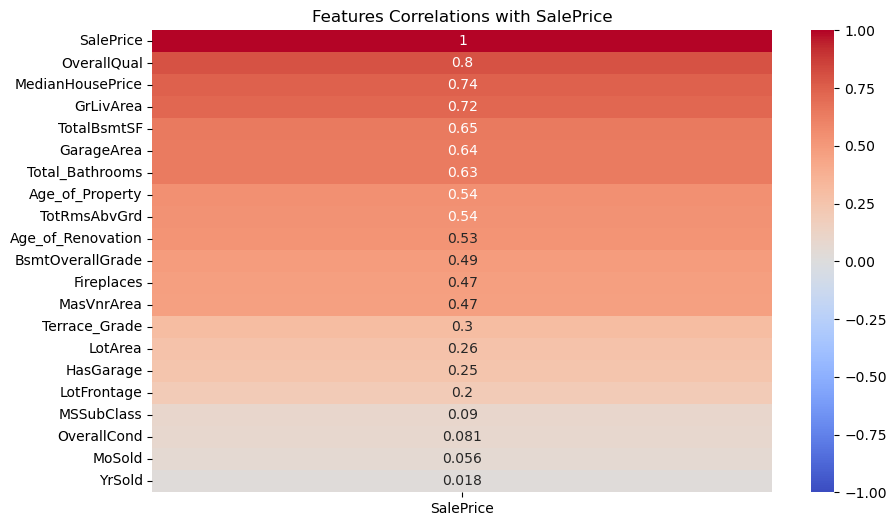

In [288]:
target_column = 'SalePrice'
corr_matrix = df5.corr()
corr_with_target = corr_matrix[target_column].apply(np.abs).sort_values(ascending=False)


plt.figure(figsize=(10, 6))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title(f'Features Correlations with {target_column}')
plt.show()

In [289]:
features_drop_low_correlation_numeric = []
for i,v in corr_with_target.iteritems():
    if (abs(v) < 0.2):
        features_drop_low_correlation_numeric.append(i)
features_drop_low_correlation_numeric

['LotFrontage', 'MSSubClass', 'OverallCond', 'MoSold', 'YrSold']

In [290]:
df6 = df5.drop(columns=features_drop_low_correlation_numeric)
print(df5.shape, ' ---> ', df6.shape)

(1451, 47)  --->  (1451, 42)


### Categorical Variables

**ANOVA & Boxplots**

In [291]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [292]:
categorical_columns = df6.select_dtypes(include='object').columns
drop_col_for_ANOVA = []
p_values_ANOVA = {}
for col in categorical_columns:
    str_ANOVA_item = 'SalePrice' + ' ~ C(' + col + ')'
    model = ols( str_ANOVA_item , data=df6).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    p_value = (anova_table['PR(>F)'][0])
    p_values_ANOVA[col] = p_value

for i,v in p_values_ANOVA.items():
    if v>0.05:
        drop_col_for_ANOVA.append(i)
        print(i, v)
drop_col_for_ANOVA

LandSlope 0.1013708113484022


['LandSlope']

In [293]:
df7 = df6.drop(columns=drop_col_for_ANOVA)
print(df6.shape, ' ---> ', df7.shape)

(1451, 42)  --->  (1451, 41)


**I checked ANOVA scores and only 'LandSlope' will be dropped, and nothing else understood**  
**I also checked boxplots but nothing significant came**  
**Now i will try encoding and then check correlations with TARGET**

In [294]:
df7.sample(3)

,MSZoning,LotArea,Alley,LotShape,LandContour,LotConfig,Condition1,BldgType,HouseStyle,OverallQual,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,TotalBsmtSF,HeatingQC,CentralAir,Electrical,GrLivArea,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageArea,PavedDrive,Fence,SaleType,SaleCondition,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
255,RL,8738,No Alley Access,IR1,Lvl,Inside,Norm,1Fam,2Story,7,Gable,VinylSd,VinylSd,BrkFace,302.0,Gd,TA,PConc,975,Ex,Y,SBrkr,2291,Gd,8,Typ,1,TA,429,Y,No Fence,WD,Normal,230000,2.5,11,11,1,181000.0,9.00,192
676,RM,9600,Grvl,Reg,Lvl,Inside,Norm,1Fam,2Story,4,Gable,AsbShng,Stucco,None,0.0,TA,TA,BrkTil,1095,Fa,N,SBrkr,1774,TA,8,Min2,0,No FirePlace,779,N,No Fence,WD,Normal,87000,3.0,110,60,1,119000.0,7.00,180
373,RL,10634,No Alley Access,Reg,Lvl,Inside,Norm,1Fam,1Story,5,Gable,MetalSd,MetalSd,None,0.0,TA,TA,PConc,608,TA,Y,SBrkr,1319,TA,5,Min2,0,No FirePlace,270,Y,GdWo,WD,Normal,123000,2.0,57,57,1,140000.0,10.41,66


In [295]:
categorical_columns = df7.select_dtypes(include='object').columns
categorical_columns

Index(['MSZoning', 'Alley', 'LotShape', 'LandContour', 'LotConfig',
       'Condition1', 'BldgType', 'HouseStyle', 'RoofStyle', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
       'FireplaceQu', 'PavedDrive', 'Fence', 'SaleType', 'SaleCondition'],
      dtype='object')

In [296]:
df_encoded_temporary = pd.get_dummies(df7[categorical_columns], drop_first=True)

In [297]:
df_encoded_temporary['SalePrice'] = df7['SalePrice']
target_column = 'SalePrice'
corr_matrix = df_encoded_temporary.corr()
corr_with_target = corr_matrix[target_column].apply(np.abs).sort_values(ascending=False)

corr_with_target.nlargest(20)

SalePrice                   1.000000
ExterQual_TA                0.601943
KitchenQual_TA              0.532142
Foundation_PConc            0.509228
FireplaceQu_No FirePlace    0.482039
ExterQual_Gd                0.466373
MasVnrType_None             0.388465
SaleType_New                0.383844
SaleCondition_Partial       0.378062
FireplaceQu_Gd              0.366363
MasVnrType_Stone            0.355214
Foundation_CBlock           0.348790
KitchenQual_Gd              0.341609
Exterior2nd_VinylSd         0.332905
Exterior1st_VinylSd         0.331657
HeatingQC_TA                0.318373
MSZoning_RM                 0.298427
LotShape_Reg                0.262835
SaleType_WD                 0.262797
CentralAir_Y                0.259747
Name: SalePrice, dtype: float64

In [298]:
corr_of_categoric_columns = {}
for col in categorical_columns:
    corr_of_categoric_columns[col] = []
    vc = df7[col].value_counts(normalize=True)
    
    #iterate through corr matrix index and values
    for i,v in corr_with_target.items():
        c_sc = i.split('_')
        if col == c_sc[0]:
            
            #find the weight of sub-categories depending on frequncy
            weight = vc[c_sc[1]]
            corr_for_sub_cateory = v * weight
            corr_of_categoric_columns[col].append(corr_for_sub_cateory)
            
corr_of_categoric_columns = {key: sum(value) for key, value in corr_of_categoric_columns.items()}
corr_of_categoric_columns_df = pd.DataFrame(list(corr_of_categoric_columns.items()), columns=['Categorical Feature', 'Correlation with SalePrice'])
corr_of_categoric_columns_df.sort_values(by='Correlation with SalePrice', ascending=False)

,Categorical Feature,Correlation with SalePrice
12,ExterQual,0.532128
18,KitchenQual,0.410782
14,Foundation,0.378980
20,FireplaceQu,0.358810
11,MasVnrType,0.321795
23,SaleType,0.260559
0,MSZoning,0.249689
16,CentralAir,0.242741
17,Electrical,0.231677
21,PavedDrive,0.222591


In [299]:
features_drop_low_correlation_categoric = corr_of_categoric_columns_df[corr_of_categoric_columns_df['Correlation with SalePrice']<0.20] \
                                         ['Categorical Feature'].to_list()

In [300]:
features_drop_low_correlation_categoric

['Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'Condition1',
 'BldgType',
 'HouseStyle',
 'Exterior1st',
 'Exterior2nd',
 'ExterCond',
 'HeatingQC',
 'Functional',
 'Fence',
 'SaleCondition']

In [301]:
df8 = df7.drop(columns=features_drop_low_correlation_categoric)
print(df7.shape, ' ---> ', df8.shape)


(1451, 41)  --->  (1451, 27)


## Relationships Among Independent Variables & MultiCollinearity

### Correlations

**Correlations and Eigenvalues**
Note: Compute the eigenvalues of the correlation matrix. If there are one or more eigenvalues that are close to zero, it suggests the presence of multicollinearity.

In [302]:
# Correlation Matrix of Numeric Variables

df8.drop(columns=['SalePrice']).corr()[
                                        (df8.drop(columns=['SalePrice']).corr() >=0.5) &
                                        (df8.drop(columns=['SalePrice']).corr() <1)
                                       ]

,LotArea,OverallQual,MasVnrArea,TotalBsmtSF,GrLivArea,TotRmsAbvGrd,Fireplaces,GarageArea,Total_Bathrooms,Age_of_Property,Age_of_Renovation,HasGarage,MedianHousePrice,BsmtOverallGrade,Terrace_Grade
LotArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
OverallQual,NaN,NaN,NaN,0.532286,0.584682,NaN,NaN,0.554621,0.528107,NaN,NaN,NaN,0.696963,NaN,NaN
MasVnrArea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalBsmtSF,NaN,0.532286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.503140,0.530756,NaN
GrLivArea,NaN,0.584682,NaN,NaN,NaN,0.832781,NaN,NaN,0.588286,NaN,NaN,NaN,NaN,NaN,NaN
TotRmsAbvGrd,NaN,NaN,NaN,NaN,0.832781,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fireplaces,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GarageArea,NaN,0.554621,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.538018,0.542680,NaN,NaN
Total_Bathrooms,NaN,0.528107,NaN,NaN,0.588286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.506526,0.511239,NaN
Age_of_Property,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.592816,NaN,NaN,NaN,NaN


In [303]:
# Eigenvalues of correlation matrix for numeric variables
eigenvalues, _ = np.linalg.eig(df8.drop(columns=['SalePrice']).corr())

# Print the eigenvalues
print("Eigenvalues:")
print(eigenvalues)

Eigenvalues:
[5.6732015  1.79153741 1.14801451 1.11337901 0.8828968  0.84359364
 0.67969344 0.65099881 0.56931496 0.11856459 0.40394864 0.33743075
 0.23879808 0.2523241  0.29630377]


**TotRmsAbvGrd and GrLivArea** represents a multi collinearity. Maybe i could choose Bedrooms Above Ground rather than total rooms abv grd  
Eigenvalues are not very close to Zero, so it doesnt directly refer a multicollinearity issues

### Variance Inflation Factor (VIF)

In [304]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [305]:
df_encoded_temporary = pd.get_dummies(df8.select_dtypes(include='object'), drop_first=True)

df_combined_temporary = pd.concat([df8.select_dtypes(include='number'), df_encoded_temporary], axis=1).drop(columns=['SalePrice'])

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = df_combined_temporary.columns
vif_data["VIF"] = [variance_inflation_factor(df_combined_temporary.values, i) for i in range(df_combined_temporary.shape[1])]

vif_data.sort_values(by='VIF', ascending=False).head(30)

,feature,VIF
17,MSZoning_RL,120.070279
19,RoofStyle_Gable,86.109945
1,OverallQual,74.300200
5,TotRmsAbvGrd,68.837809
4,GrLivArea,65.399707
26,MasVnrType_None,57.652066
47,FireplaceQu_No FirePlace,40.727236
30,ExterQual_TA,37.277718
12,MedianHousePrice,34.695420
59,SaleType_WD,31.633078


**VIF has become one of the most important analysis of this feature engineering study. It gives too much inspirations**  
  
**1. Overall Quality** has very high VIF, we also observed this in correlation matrix it has positive bonds with some other features but none of them is more than 0.8. This is actually very normal since it is some sort of a summary of the house. Moreover, it has 0.8 correlation with SalesPrice, so i will **not drop** it but i surely will think more of this and its related features, after initial model results.    
  
**2. TotRmsAbvGrd and  GrLivArea** also priduced high VIf. we also observed this in correlation matrix. And as general domain knowledge this is normal. However i will **not remove** this combination. **BUT** when i iterate the model with other combinations i will choose to drop one or change one with **TotalBedroomsAbvGrd**  
  
**3. HasGarage GarageAre** i think i need to **drop** this since GarageArea and HasGarage is correlated because if GarageArea is 0 then HasGarage is also 0  
  
for a detailed eye, there are more inferences but i think this is enough for now

### Cramers V

**Cramers V is used for categorical variables only**

In [306]:
from data_downloaded.fatih_eda import calculate_cramersV

In [307]:
calculate_cramersV(df8, df8.select_dtypes(include='object').columns, treshold=0.4)

{('ExterQual', 'KitchenQual'): 0.5384477144566122,
 ('CentralAir', 'Electrical'): 0.42483768438460784,
 ('Electrical', 'CentralAir'): 0.42483768438460784,
 ('KitchenQual', 'ExterQual'): 0.5384477144566122}

**'KitchenQual', 'ExterQual'** : It seems like there is a strong association between two pairs. Also: VIF scored showed similar results. I think this association can be real since, the quality of one part of the home can be associated to another part. Since ExterQual has a higher correlation with SalesPrice, i will **drop KitchenQual** from the dataset

### Drop Columns for Multicollinearity

In [308]:
df9 = df8.drop(columns=['HasGarage', 'KitchenQual'])
print(df8.shape, ' ---> ', df9.shape)

(1451, 27)  --->  (1451, 25)


**Test Data**

In [309]:
df_test_4 = df_test_3.drop(columns=cardinality_drop_columns)
# df4 --> df5 outliers (we did not drop any columns but only observations from training data in outliers section)
df_test_6 = df_test_4.drop(columns=features_drop_low_correlation_numeric)  
df_test_7 = df_test_6.drop(columns=drop_col_for_ANOVA)
df_test_8 = df_test_7.drop(columns=features_drop_low_correlation_categoric)
df_test_9 = df_test_8.drop(columns=['HasGarage', 'KitchenQual'])
print(df_test_9.shape)

(1459, 24)


**It seems like there 2 columns more after encoding in the train data. Lets check and find them**
I found this later, but took into this part to delete Electrical column. Test and train data is not aligned, different values exist. Since this feature is not effecting SalePrice so much, i consider to remove Electrical from Both datasets.

In [310]:
df9.Electrical.value_counts()

SBrkr            1326
FuseA              93
FuseF              27
FuseP               3
Mix                 1
No Electrical       1
Name: Electrical, dtype: int64

In [311]:
df_test_9.Electrical.value_counts()

SBrkr    1337
FuseA      94
FuseF      23
FuseP       5
Name: Electrical, dtype: int64

In [312]:
df9.drop(columns=['Electrical'], inplace=True)
df_test_9.drop(columns=['Electrical'], inplace=True)

## Observing Distributions and Skewnesses & Transformations

In [313]:
from data_downloaded.fatih_eda import plot_histograms_for_all_numeric, plot_barplot_all_categoric

**Apply Log Transformation to Skewed Features**

In [315]:
log_transform_num_columns = ['SalePrice', 'LotArea']
small_constant = 0.001   # this is to prevent infinity after log transformation

df9[log_transform_num_columns] = np.log(df9[log_transform_num_columns] + small_constant)

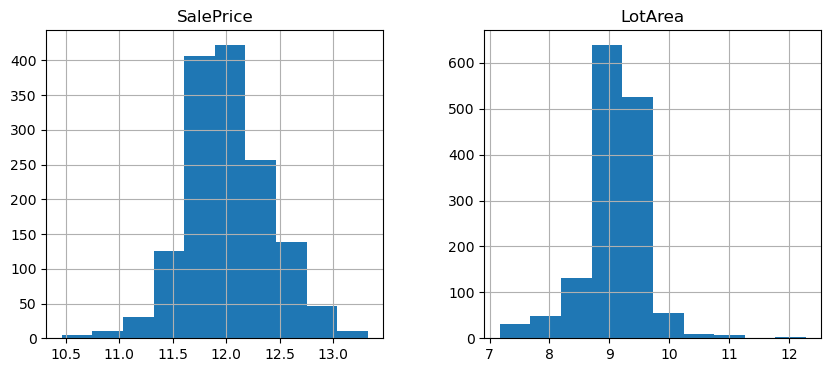

In [316]:
df9[['SalePrice', 'LotArea']].hist(figsize=(10,4));

**Test Data**

In [317]:
small_constant = 0.001   # this is to prevent infinity after log transformation
df_test_9['LotArea'] = np.log(df_test_9['LotArea'] + small_constant)

# Encode categorical variables

In [318]:
# Discriminate the categorical variables
nominal_categorical_vars = ['MSZoning', 'RoofStyle', 'MasVnrType', 'Foundation', 'SaleType']
ordinal_categorical_vars = ['ExterQual', 'FireplaceQu', 'PavedDrive', 'CentralAir']

In [319]:
# Prepare Labels for Ordinal Encoding
ordinal_mapping = {
    'ExterQual': {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},  # Quality of the material on the exterior
    'FireplaceQu': {'No Fireplace': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5},  # Fireplace quality
    'PavedDrive': {'N': 0, 'P': 1, 'Y': 2},  # Paved driveway
    'CentralAir': {'N': 0, 'Y': 1}  # Central air conditioning
}

In [320]:
# Apply Ordinal Encoding
for var in ordinal_categorical_vars:
    df9[var] = df9[var].map(ordinal_mapping[var])

In [321]:
# Apply Nominal Encoding
df_encoded = pd.get_dummies(df9[nominal_categorical_vars], columns=nominal_categorical_vars)
df9 = pd.concat([df9, df_encoded], axis=1)
df10 = df9.drop(columns=nominal_categorical_vars)

In [322]:
df10.sample(2)

,LotArea,OverallQual,MasVnrArea,ExterQual,TotalBsmtSF,CentralAir,GrLivArea,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageArea,PavedDrive,SalePrice,Total_Bathrooms,Age_of_Property,Age_of_Renovation,MedianHousePrice,BsmtOverallGrade,Terrace_Grade,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_No MasVnr,MasVnrType_None,MasVnrType_Stone,Foundation_BrkTil,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
364,9.841612,6,120.0,3,796,1,1574,6,1,3.0,566,2,12.154779,3.5,34,34,182900.0,15.0,417,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
667,9.002701,6,258.0,3,1408,1,1679,7,1,2.0,575,2,12.173033,3.0,16,12,179900.0,14.0,266,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [323]:
df10.shape

(1451, 50)

**Test Data**

In [324]:
# Apply Ordinal Encoding
for var in ordinal_categorical_vars:
    df_test_9[var] = df_test_9[var].map(ordinal_mapping[var])

In [325]:
# Apply Nominal Encoding
df_encoded = pd.get_dummies(df_test_9[nominal_categorical_vars], columns=nominal_categorical_vars)
df_test_9 = pd.concat([df_test_9, df_encoded], axis=1)
df_test_10 = df_test_9.drop(columns=nominal_categorical_vars)
print(df_test_10.shape)

(1459, 49)


---------------------------------------------------

# Feature & Target Dataset

In [327]:
X_train = df10.drop(columns = ['SalePrice'])
y_train = df10['SalePrice']
X_real_test = df_test_10

In [328]:
print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print(f"X test for Kaggle Predictions shape is: {X_real_test.shape}")

X_train shape is: (1451, 49)
y_train shape is: (1451,)
X test for Kaggle Predictions shape is: (1459, 49)


# Train Test Split

In [329]:
from sklearn.model_selection import train_test_split

# Linear Regression

In [544]:
print(y.shape)
print(X.shape)

(1408,)
(1408, 43)


In [545]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [546]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1126
1126
282
282


In [149]:
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [548]:
# Lets instantiate the model
model = LinearRegression()

In [549]:
# Lets train the model
model.fit(X_train, y_train)

LinearRegression()

## Cross Validation

In [550]:
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)

In [551]:
print(f'Cross-Validation RMSE Scores: {rmse_scores}')
print(f'Mean RMSE: {rmse_scores.mean()}')

Cross-Validation RMSE Scores: [0.12536683 0.13128444 0.10536382 0.10931124 0.12065442]
Mean RMSE: 0.11839614955267148


## Make Predictions

In [584]:
y_pred = model.predict(X_test)

In [585]:
y_pred

array([11.67890568, 12.01330201, 12.04162164, ..., 12.04109768,
       11.7212861 , 12.23327804])

In [586]:
predicted_prices = np.exp(y_pred)
predicted_prices

array([118054.97468923, 164934.22025757, 169671.86482776, ...,
       169582.98646572, 123165.72636614, 205515.76859394])

In [162]:
len(predicted_prices)

NameError: name 'predicted_prices' is not defined

# XGBOoost 

In [150]:
import xgboost as xgb

In [165]:
y.shape

(1408,)

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [161]:
print(len(X_train))
print(len(y_train))
print(len(X_test))
print(len(y_test))

1126
1126
282
282


In [152]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                          max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [153]:
y_pred = xg_reg.predict(X_test)

In [154]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)


RMSE: 0.2597749166152658


In [155]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the hyperparameters and their ranges to search
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 2, 3]
}

# Create an instance of the XGBoost Regressor
xgb = XGBRegressor()

# Create a GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 4, 5], 'min_child_weight': [1, 2, 3],
                         'n_estimators': [100, 200, 300]},
             scoring='neg_mean_squared_error', verbose=1)

In [156]:
grid_search.best_params_

{'learning_rate': 0.1,
 'max_depth': 3,
 'min_child_weight': 2,
 'n_estimators': 200}

In [172]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

In [173]:
len(y_pred)

282

In [175]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 0.12325260237383662


__Predict Real Values__

In [179]:
y_pred_xgb = best_model.predict(X_test_gercek)

In [180]:
predicted_prices_xgb = np.exp(y_pred_xgb)
len(predicted_prices_xgb)

1459

# 9. Submitting to Kaggle

In [587]:
df_submit1 = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': predicted_prices})
df_submit1

,Id,SalePrice
0,1461,118054.974689
1,1462,164934.220258
2,1463,169671.864828
3,1464,192684.514740
4,1465,197130.013402
...,...,...
1454,2915,95240.676151
1455,2916,84662.208760
1456,2917,169582.986466
1457,2918,123165.726366


In [181]:
df_submit2 = pd.DataFrame({'Id': df_test['Id'], 'SalePrice': predicted_prices_xgb})
df_submit2

,Id,SalePrice
0,1461,123850.984375
1,1462,173231.578125
2,1463,179380.281250
3,1464,202371.640625
4,1465,177925.437500
...,...,...
1454,2915,91093.210938
1455,2916,84497.453125
1456,2917,163244.609375
1457,2918,124470.242188


In [588]:
#df_submit1.to_csv('data_downloaded/fatih_real_estate_subm01.csv', index=False)

In [182]:
df_submit2.to_csv('data_downloaded/fatih_real_estate_subm02_xgb.csv', index=False)